# Simple Image Classification Using the MNIST Dataset
Nanyan "Rosalie" Zhu and Chen "Raphael" Liu

This notebook belongs to this repository ["RnR-2018/BMEN4460-NB2-image_classification_on_MNIST_data"](https://github.com/RnR-2018/BMEN4460-NB2-image_classification_on_MNIST_data) and its parent repository ["RnR-2018/Deep-learning-with-PyTorch-and-GCP"](https://github.com/RnR-2018/Deep-learning-with-PyTorch-and-GCP).

This notebook is inspired by and largely adapted from [this GitHub repository](https://github.com/jkotra/mnist-pytorch).

### Import the necessary packages.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader

import tensorflow.keras.datasets.mnist as MNIST

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings

### Check GPU availability (should be False if you run the CPU VM and True if you run the GPU VM).

In [2]:
cuda = torch.cuda.is_available()
print("GPU available:", cuda)

GPU available: True


### Set the random seed for reproducibility.

The random seed helps to make sure that the model parameter initialization, sequence of random shuffling, and most other nondeterministic operations are kept the same each time you run this notebook.

In [3]:
torch.manual_seed(20204460)
np.random.seed(20204460)

### Download the MNIST handwritten digits dataset.

It is designed to have a 60k-image train set and a 10k-image test set. We are not going to use all of them for this tutorial because that will eat up quite a bit of memory.

In [4]:
(image_MNIST_train_set, label_MNIST_train_set), (image_MNIST_test_set, label_MNIST_test_set) = MNIST.load_data()

#### Display some sample images and labels.

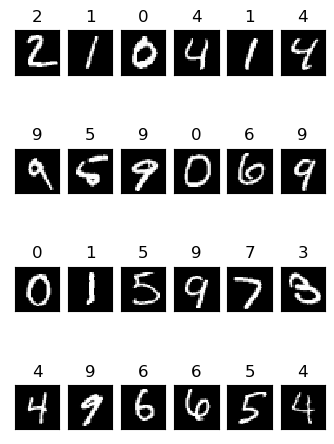

In [5]:
row = 4
col = 6
fig = plt.figure(figsize = (row, col), dpi = 100)

for image_index in range(1, row * col + 1):
    image = image_MNIST_test_set[image_index, :, :]
    ax = fig.add_subplot(row, col, image_index)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_text(str(label_MNIST_test_set[image_index]))
    plt.imshow(image, cmap = 'gray')

plt.show()

### We have 70k images in total, but we will only use a subset of it for this tutorial.

#### Let's just use what MNIST originally allocated as the test set as our entire dataset (N = 10k) and perform a 8:1:1 train:validation:test split.

In [6]:
# Split the 10000 MNIST test set into our train set (N = 8e3) and validation+test set (N = 2e3) at an 8:2 ratio.
indices_train, indices_validation_and_test = train_test_split(range(len(image_MNIST_test_set)), test_size = 0.2)
image_train = image_MNIST_test_set[indices_train, :, :]
label_train = label_MNIST_test_set[indices_train]
image_validation_and_test = image_MNIST_test_set[indices_validation_and_test, :, :]
label_validation_and_test = label_MNIST_test_set[indices_validation_and_test]

# Split the validation+test set into the validation set (N = 5e3) and the test set (N = 5e3).
# Note that we are using the package "train_test_split" but what we are actually doing here is validation test split.
indices_validation, indices_test = train_test_split(range(len(image_validation_and_test)), test_size = 0.5)
image_validation = image_validation_and_test[indices_validation, :, :]
label_validation = label_validation_and_test[indices_validation]
image_test = image_validation_and_test[indices_test, :, :]
label_test = label_validation_and_test[indices_test]

print('Images: train %d, validation %d, test %d \nLabels: train %d, validation %d, test %d' % \
      (len(image_train), len(image_validation), len(image_test), len(label_train), len(label_validation), len(label_test)))

Images: train 8000, validation 1000, test 1000 
Labels: train 8000, validation 1000, test 1000


### Reformat the images and labels so that they can be fed into the data loader.
Normally you would construct a validation loader and a test loader similar to how we construct the train loader, but for this case since the validation and test set only consists of 1000 28$\times$28 images each, we can just get away with not using a data loader at all.

In [7]:
image_train_torch = torch.from_numpy(image_train).type(torch.FloatTensor).view(-1, 1, 28, 28)
label_train_torch = torch.from_numpy(label_train).type(torch.LongTensor)

image_validation_torch = torch.from_numpy(image_validation).type(torch.FloatTensor).view(-1, 1, 28, 28)
label_validation_torch = torch.from_numpy(label_validation).type(torch.LongTensor)

image_test_torch = torch.from_numpy(image_test).type(torch.FloatTensor).view(-1, 1, 28, 28)
label_test_torch = torch.from_numpy(label_test).type(torch.LongTensor)

train_data = TensorDataset(image_train_torch, label_train_torch)
train_loader = DataLoader(train_data, batch_size = 1000)

### Build our classification network.

This architecture comes from [this GitHub repository](https://github.com/floydhub/mnist).

<img src="data/MNIST_CNN.png" width="1200" align="center"/>

In [8]:
# Formula to calculate shape as we go through layer by layer = [(X - F + 2P)/S] + 1
# Here,
# X = Width / Height
# F = Kernel size
# P = Padding
# S = Strides (default = 1)

# Our input to the first layer is going to be [batchsize, 1, 28, 28]
# substitute, =[(28 - 5 + 2(0))/1] + 1
#             =[(23)/1] + 1
#             =23 + 1
#             =24


class Model(nn.Module):
    '''ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX'''
    def __init__(self):
        '''Define model modules.'''
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5, 1)
        self.conv2 = nn.Conv2d(10, 20, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 20, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        '''Define the model architecture (the sequence to place the model modules).'''
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)

our_CNN = Model()

# If GPU available, move the model to GPU.
if cuda:
    our_CNN.cuda()

print(our_CNN)

Model(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


#### Visualize kernels

The shape of the weights:  torch.Size([10, 1, 5, 5])
filter 0 min value:  -0.1952027529478073 , max value: 0.1967245191335678
filter 1 min value:  -0.19775216281414032 , max value: 0.19976700842380524
filter 2 min value:  -0.15170109272003174 , max value: 0.19543324410915375
filter 3 min value:  -0.1970035880804062 , max value: 0.1823096126317978
filter 4 min value:  -0.19860005378723145 , max value: 0.18713442981243134
filter 5 min value:  -0.1983514130115509 , max value: 0.1939190775156021
filter 6 min value:  -0.1795956939458847 , max value: 0.1938774734735489
filter 7 min value:  -0.19251863658428192 , max value: 0.1914764791727066
filter 8 min value:  -0.19645391404628754 , max value: 0.1813836246728897
filter 9 min value:  -0.17982669174671173 , max value: 0.19924910366535187


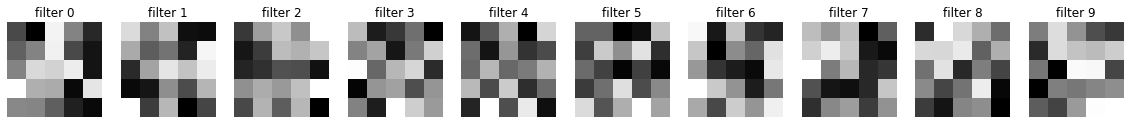

In [9]:
params = our_CNN.state_dict()
plt.rcParams['figure.figsize'] = [20, 5]
for k, v in params.items():
    # get the first layer weight
    if k == 'conv1.weight':
        print('The shape of the weights: ', v.shape)
        c_int = v.size()[1]     # number of the input channels
        c_out = v.size()[0]     # number of the output channels
        
        for j in range(c_out):
            plt.subplot(1, c_out, j + 1)
            kernel = np.squeeze(v[j, :, :, :].cpu())
            print('filter ' + str(j), 'min value: ', kernel.min().item(), ', max value:', kernel.max().item())
            plt.imshow(kernel, cmap = 'gray')
            plt.title('filter ' + str(j))
            plt.axis('off');


#### Visualize our sample data

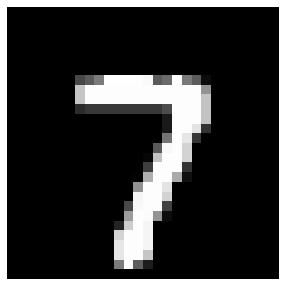

In [11]:
data, label = next(iter(train_loader))
sample_data = data[1, :, :, :]
plt.imshow(np.squeeze(sample_data.cpu().detach()), cmap = 'gray')
plt.axis('off');

#### pass the sample image into the first layer of our kernel

The shape of the feature maps:  torch.Size([1, 10, 24, 24])
feature_map 0 min value:  0.0 , max value: 216.06300354003906
feature_map 1 min value:  0.0 , max value: 111.42817687988281
feature_map 2 min value:  0.0 , max value: 217.41659545898438
feature_map 3 min value:  0.0 , max value: 70.21971130371094
feature_map 4 min value:  0.0 , max value: 34.2264404296875
feature_map 5 min value:  0.0 , max value: 112.19308471679688
feature_map 6 min value:  0.0 , max value: 156.91502380371094
feature_map 7 min value:  0.0 , max value: 179.88145446777344
feature_map 8 min value:  0.0 , max value: 147.3660888671875
feature_map 9 min value:  0.0 , max value: 279.9332580566406


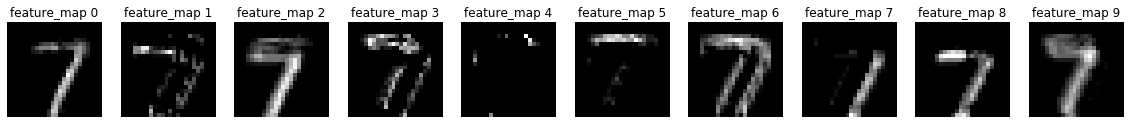

In [12]:
if cuda:
    sample_img = sample_data.unsqueeze(0).cuda()
else:
    sample_img = sample_data.unsqueeze(0)

for name, layer in our_CNN._modules.items():
    x = sample_img
    if name == 'conv1':
        x = layer(x)
        x = F.relu(x) if 'conv' in name else x
        
        print('The shape of the feature maps: ', x.shape)
        c_int = x.size()[0]     # number of the input channels
        c_out = x.size()[1]     # number of the output channels
        
        for j in range(c_out):
            plt.subplot(1, c_out, j + 1)
            feature_map = np.squeeze(x[:, j, :, :].cpu().detach())
            print('feature_map ' + str(j), 'min value: ', feature_map.min().item(), ', max value:', feature_map.max().item())
            plt.imshow(feature_map, cmap = 'gray')
            plt.title('feature_map ' + str(j))
            plt.axis('off');
             

#### Define our optimizer.

In [13]:
# define our optimizer
optimizer = SGD(our_CNN.parameters(), lr = 0.001)

#### Train our CNN for classification.

The shape of the weights:  torch.Size([10, 1, 5, 5])
filter 0 min value:  -0.19600872695446014 , max value: 0.19047687947750092
filter 1 min value:  -0.2012130618095398 , max value: 0.19595254957675934
filter 2 min value:  -0.15486590564250946 , max value: 0.1906013935804367
filter 3 min value:  -0.19737164676189423 , max value: 0.1826225370168686
filter 4 min value:  -0.1988564431667328 , max value: 0.18554572761058807
filter 5 min value:  -0.19834473729133606 , max value: 0.19162677228450775
filter 6 min value:  -0.17755967378616333 , max value: 0.19353829324245453
filter 7 min value:  -0.192549929022789 , max value: 0.18671612441539764
filter 8 min value:  -0.19738346338272095 , max value: 0.17093117535114288
filter 9 min value:  -0.18307620286941528 , max value: 0.19090652465820312


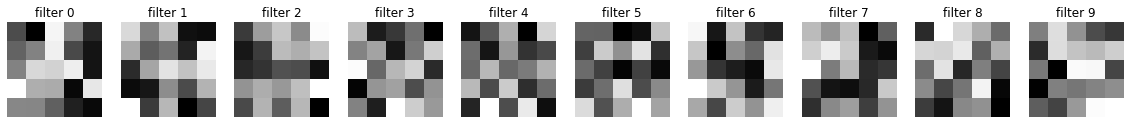

The shape of the feature maps:  torch.Size([1, 10, 24, 24])


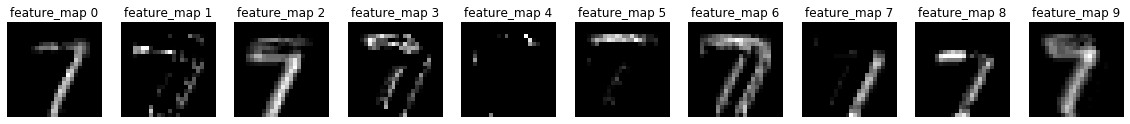

Epoch: 0 | train_loss: 5.365622669458389 | validation_loss: 4.14507582783699
Epoch: 1 | train_loss: 2.1477286964654922 | validation_loss: 2.0781160295009613
Epoch: 2 | train_loss: 1.7150009870529175 | validation_loss: 1.6841303706169128
Epoch: 3 | train_loss: 1.41792830824852 | validation_loss: 1.4040143936872482
Epoch: 4 | train_loss: 1.1895094960927963 | validation_loss: 1.187541902065277
Epoch: 5 | train_loss: 1.0201418548822403 | validation_loss: 1.025242142379284
Epoch: 6 | train_loss: 0.8910167887806892 | validation_loss: 0.9009859785437584
Epoch: 7 | train_loss: 0.7911502122879028 | validation_loss: 0.8061347454786301
Epoch: 8 | train_loss: 0.7125504836440086 | validation_loss: 0.7312761098146439
Epoch: 9 | train_loss: 0.6488602235913277 | validation_loss: 0.6711285412311554
The shape of the weights:  torch.Size([10, 1, 5, 5])
filter 0 min value:  -0.1880827248096466 , max value: 0.19322969019412994
filter 1 min value:  -0.2021421641111374 , max value: 0.19305728375911713
filter

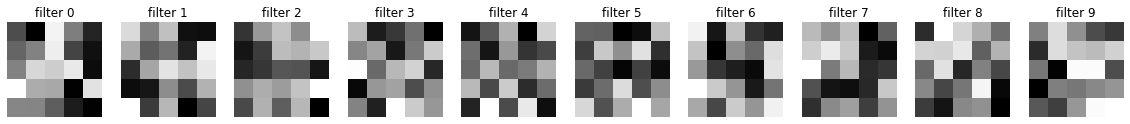

The shape of the feature maps:  torch.Size([1, 10, 24, 24])


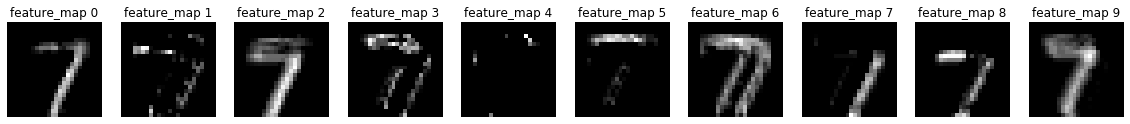

Epoch: 10 | train_loss: 0.5969463288784027 | validation_loss: 0.6228205636143684
Epoch: 11 | train_loss: 0.5537934191524982 | validation_loss: 0.5828677043318748
Epoch: 12 | train_loss: 0.5172886177897453 | validation_loss: 0.5491354241967201
Epoch: 13 | train_loss: 0.48649607226252556 | validation_loss: 0.5201747119426727
Epoch: 14 | train_loss: 0.4601834714412689 | validation_loss: 0.4951137974858284
Epoch: 15 | train_loss: 0.4370631128549576 | validation_loss: 0.4732147715985775
Epoch: 16 | train_loss: 0.4168235957622528 | validation_loss: 0.454192154109478
Epoch: 17 | train_loss: 0.39878327772021294 | validation_loss: 0.4369506165385246
Epoch: 18 | train_loss: 0.3824440948665142 | validation_loss: 0.4211338199675083
Epoch: 19 | train_loss: 0.36767715215682983 | validation_loss: 0.4070267863571644
The shape of the weights:  torch.Size([10, 1, 5, 5])
filter 0 min value:  -0.18784219026565552 , max value: 0.19604909420013428
filter 1 min value:  -0.20207622647285461 , max value: 0.192

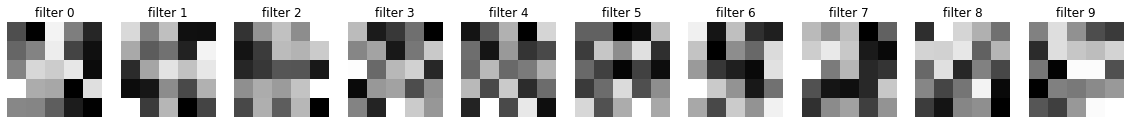

The shape of the feature maps:  torch.Size([1, 10, 24, 24])


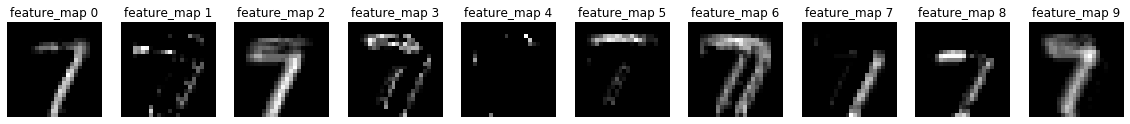

Epoch: 20 | train_loss: 0.3541276678442955 | validation_loss: 0.3946778066456318
Epoch: 21 | train_loss: 0.34179312735795975 | validation_loss: 0.38344831392169
Epoch: 22 | train_loss: 0.3302284777164459 | validation_loss: 0.3731550946831703
Epoch: 23 | train_loss: 0.3194890581071377 | validation_loss: 0.3635157123208046
Epoch: 24 | train_loss: 0.309505395591259 | validation_loss: 0.35468560084700584
Epoch: 25 | train_loss: 0.30024024844169617 | validation_loss: 0.34656061232089996
Epoch: 26 | train_loss: 0.2915116064250469 | validation_loss: 0.3389814607799053
Epoch: 27 | train_loss: 0.28340955823659897 | validation_loss: 0.33193082734942436
Epoch: 28 | train_loss: 0.2758928034454584 | validation_loss: 0.3254658132791519
Epoch: 29 | train_loss: 0.2687051948159933 | validation_loss: 0.31947674974799156
The shape of the weights:  torch.Size([10, 1, 5, 5])
filter 0 min value:  -0.18915313482284546 , max value: 0.1980411410331726
filter 1 min value:  -0.20231716334819794 , max value: 0.19

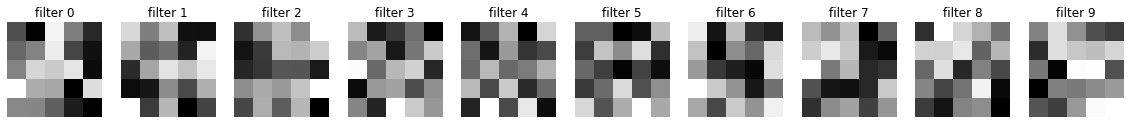

The shape of the feature maps:  torch.Size([1, 10, 24, 24])


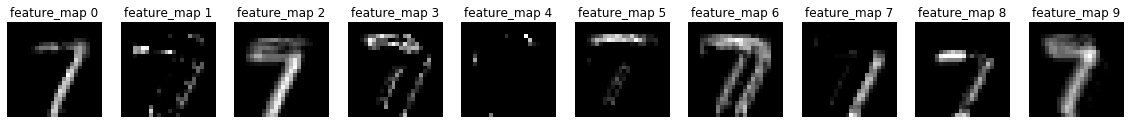

Epoch: 30 | train_loss: 0.2619558647274971 | validation_loss: 0.3138485439121723
Epoch: 31 | train_loss: 0.2556765265762806 | validation_loss: 0.3084294982254505
Epoch: 32 | train_loss: 0.24961226247251034 | validation_loss: 0.3033972941339016
Epoch: 33 | train_loss: 0.2438242882490158 | validation_loss: 0.2986367382109165
Epoch: 34 | train_loss: 0.2383242528885603 | validation_loss: 0.29415080323815346
Epoch: 35 | train_loss: 0.23316188901662827 | validation_loss: 0.2898753322660923
Epoch: 36 | train_loss: 0.22817356698215008 | validation_loss: 0.285808227956295
Epoch: 37 | train_loss: 0.22343757189810276 | validation_loss: 0.28208596631884575
Epoch: 38 | train_loss: 0.21891207434237003 | validation_loss: 0.27854737639427185
Epoch: 39 | train_loss: 0.21461474895477295 | validation_loss: 0.27514219656586647
The shape of the weights:  torch.Size([10, 1, 5, 5])
filter 0 min value:  -0.1901889145374298 , max value: 0.199605792760849
filter 1 min value:  -0.20272503793239594 , max value: 0

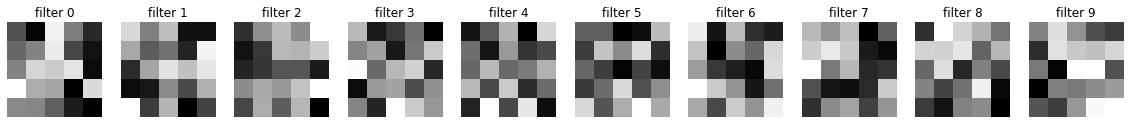

The shape of the feature maps:  torch.Size([1, 10, 24, 24])


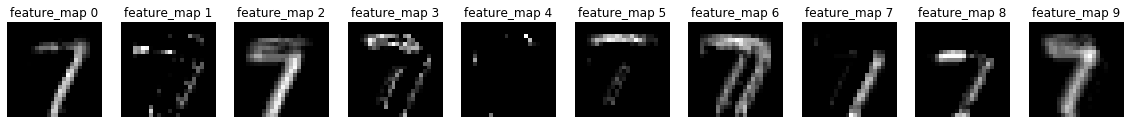

Epoch: 40 | train_loss: 0.2104166727513075 | validation_loss: 0.27179789543151855
Epoch: 41 | train_loss: 0.20636961609125137 | validation_loss: 0.2685241028666496
Epoch: 42 | train_loss: 0.202509181573987 | validation_loss: 0.26552047207951546
Epoch: 43 | train_loss: 0.1987678576260805 | validation_loss: 0.2625433914363384
Epoch: 44 | train_loss: 0.19522840715944767 | validation_loss: 0.2596866004168987
Epoch: 45 | train_loss: 0.1918133981525898 | validation_loss: 0.2568371668457985
Epoch: 46 | train_loss: 0.18849769234657288 | validation_loss: 0.25436193495988846
Epoch: 47 | train_loss: 0.18531766906380653 | validation_loss: 0.2520151771605015
Epoch: 48 | train_loss: 0.1822340190410614 | validation_loss: 0.24969900026917458
Epoch: 49 | train_loss: 0.17924355529248714 | validation_loss: 0.24743853695690632


In [14]:
EPOCHS = 50

train_epoch_loss = []
validation_epoch_loss = []

for epoch in range(EPOCHS):
    train_loss = []
    validation_loss = []

    for batch_index, (train_image, train_label) in enumerate(train_loader):
        # If GPU is available, move the data to the GPU for faster computation.
        if cuda:
            #######################################################
            ####################### Train #########################
            #######################################################
            # Set the model to train mode so that the parameters can be updated.
            our_CNN.train()

            train_label_predicted = our_CNN(train_image.cuda())

            # compute the loss
            loss = F.cross_entropy(train_label_predicted, train_label.cuda())
            train_loss.append(loss.cpu().data.item())

            # reset the gradient 
            optimizer.zero_grad()
            # backpropagate the loss
            loss.backward()
            # update the parameters
            optimizer.step()

            #######################################################
            ###################### Validation #####################
            #######################################################
            # Set the model to evaluation mode so that parameters are fixed.
            our_CNN.eval()

            validation_label_predicted = our_CNN(image_validation_torch.cuda())

            loss = F.cross_entropy(validation_label_predicted, label_validation_torch.cuda())
            validation_loss.append(loss.cpu().data.item())
            
        
        # If GPU is not available.
        else:
            #######################################################
            ####################### Train #########################
            #######################################################
            # Set the model to train mode so that the parameters can be updated.
            our_CNN.train()

            train_label_predicted = our_CNN(train_image)

            # compute the loss
            loss = F.cross_entropy(train_label_predicted, train_label)
            train_loss.append(loss.cpu().data.item())

            # reset the gradient
            optimizer.zero_grad()
            # backpropagate the loss
            loss.backward()
            # update the parameters
            optimizer.step()

            #######################################################
            ###################### Validation #####################
            #######################################################
            # Set the model to evaluation mode so that parameters are fixed.
            our_CNN.eval()

            validation_label_predicted = our_CNN(image_validation_torch)

            loss = F.cross_entropy(validation_label_predicted, label_validation_torch)
            validation_loss.append(loss.cpu().data.item())

    # kernal visualiztion
    our_CNN.eval()
    if epoch % 10 == 0:
        params = our_CNN.state_dict()
        plt.rcParams['figure.figsize'] = [20, 10]
        for k, v in params.items():
            # get the first layer weight
            if k == 'conv1.weight':
                print('The shape of the weights: ', v.shape)
                c_int = v.size()[1]     # number of the input channels
                c_out = v.size()[0]     # number of the output channels

                for j in range(c_out):
                    plt.subplot(1, c_out, j + 1)
                    kernel = np.squeeze(v[j, :, :, :].cpu())
                    print('filter ' + str(j), 'min value: ', kernel.min().item(), ', max value:', kernel.max().item())
                    plt.imshow(kernel, cmap = 'gray')
                    plt.title('filter ' + str(j))
                    plt.axis('off');
        plt.show()
        
        if cuda:
            sample_img = sample_data.unsqueeze(0).cuda()
        else:
            sample_img = sample_data.unsqueeze(0)
        
        for name, layer in our_CNN._modules.items():
            x = sample_img
            if name == 'conv1':
                x = layer(x)
                x = F.relu(x) if 'conv' in name else x

                print('The shape of the feature maps: ', x.shape)
                c_int = x.size()[0]     # number of the input channels
                c_out = x.size()[1]     # number of the output channels

                for j in range(c_out):
                    plt.subplot(1, c_out, j + 1)
                    feature_map = np.squeeze(x[:, j, :, :].cpu().detach())
                    plt.imshow(feature_map, cmap = 'gray')
                    plt.title('feature_map ' + str(j))
                    plt.axis('off');
        plt.show()
    train_epoch_loss.append(np.mean(train_loss))
    validation_epoch_loss.append(np.mean(validation_loss))
    
    # save models
    os.makedirs('./saved_models', exist_ok = True)
    torch.save(our_CNN.state_dict(), './saved_models/checkpoint_epoch_%s.pth' % (epoch))

    print("Epoch: {} | train_loss: {} | validation_loss: {}".format(epoch, train_epoch_loss[-1], validation_epoch_loss[-1]))

### Explanation on train, validation and test split.
While you are waiting for your CNN to be trained, let's look back on what it means to and why we need to perform a train/validation/test split.

- The train set is quite straightforward: you allocate a portion of the data to train your model.
- The test set is a set of data you keep to yourself and make sure the model doesn't have access to. You need that set of data to evaluate the performance of your model once it is ready to be challenged.
- The validation set is a set of data you quiz your model before it is ready for the "final exam" given by the test set. It gives you an idea how well the model is likely to perform on an unseen set of data.

In an ideal case, you design and train your model using the train data, adjust the hyperparameters (learning rate, etc.) and decide on when to stop the training (either by adjusting # epoch or by setting automated criteria for early stop) along with other intelligent approaches to make sure the model is likely to generalize well, and then test its performance on the test data.

#### Draw the train loss and validation loss curves.

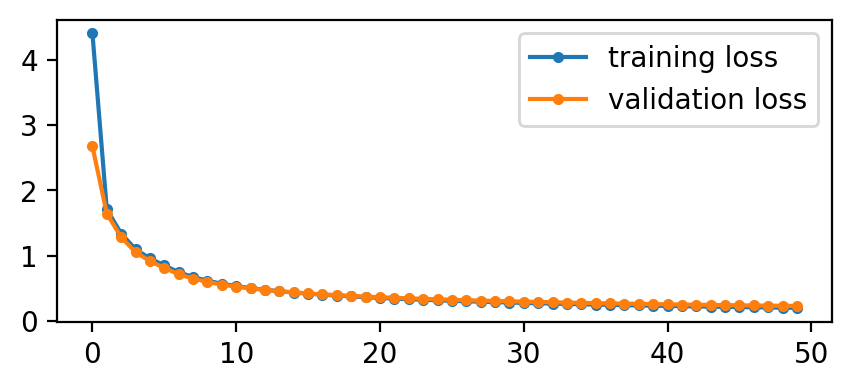

In [11]:
plt.figure(figsize = (5, 2), dpi = 200)
plt.plot(train_epoch_loss, '-o', label = 'training loss', markersize = 3)
plt.plot(validation_epoch_loss, '-o', label = 'validation loss', markersize = 3)
plt.legend(loc = 'upper right');

#### Let's check at which epoch the model performs the best on the validation set.

In [12]:
best_epoch = np.argmin(validation_epoch_loss)
print('best epoch: ', best_epoch)

best epoch:  49


#### We will call that as our best model and use that for inference on the test set.

In [13]:
state_dict = torch.load('./saved_models/checkpoint_epoch_%s.pth' % (best_epoch))
print(state_dict.keys())
our_CNN.load_state_dict(state_dict)

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias'])


<All keys matched successfully>

## Predict the labels on the test set.

### 1. Do that on a sample image.

In [14]:
def view_classify(image, probabilities, version = "MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    probabilities = probabilities.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize = (6, 9), ncols = 2)
    ax1.imshow(image.resize_(1, 28, 28).numpy().squeeze(), cmap = 'gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    ax2.bar(np.arange(10), probabilities)
    ax2.set_aspect(10)
    ax2.set_xticks(np.arange(10))
        
    ax2.set_title('Class Probability')
    ax2.set_ylim(0, 1.1)

    plt.tight_layout()

In [15]:
image_test_torch.shape

torch.Size([1000, 1, 28, 28])

In [16]:
our_CNN.eval()

sample_test_image = image_test_torch[0, :, :, :][np.newaxis, :, :, :]

if cuda:
    sample_prediction = our_CNN(sample_test_image.cuda())
else:
    sample_prediction = our_CNN(sample_test_image)

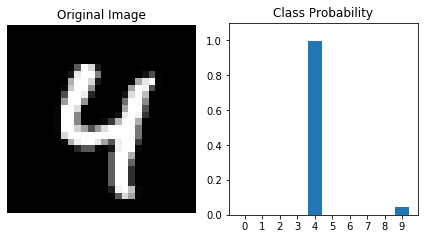

In [17]:
warnings.filterwarnings("ignore")

if cuda:
    view_classify(sample_test_image, 2 ** sample_prediction.cpu())
else:
    view_classify(sample_test_image, 2 ** sample_prediction)

### 2. This one is good, but what is the overall performance?

In [18]:
def predict_with_pytorch(model, input_data):
    model.eval()
    label_predicted_all = []

    label_predicted_one_hot = model(input_data)
    label_predicted_probability, label_predicted_index = torch.max(label_predicted_one_hot.data, 1)
    
    for current_prediction in label_predicted_index:
        label_predicted_all.append(current_prediction.detach().cpu().numpy().item())

    return label_predicted_all

In [19]:
if cuda:
    test_label_predicted = predict_with_pytorch(our_CNN, image_test_torch.cuda())
else:
    test_label_predicted = predict_with_pytorch(our_CNN, image_test_torch)

accuracy = accuracy_score(label_test, test_label_predicted)

print("Accuracy:", accuracy * 100, "%")

Accuracy: 92.9 %


### 3. Lastly, can I have a more intuitive (and cooler) way to visualize the performance?

### Yes! The answer is a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)! 

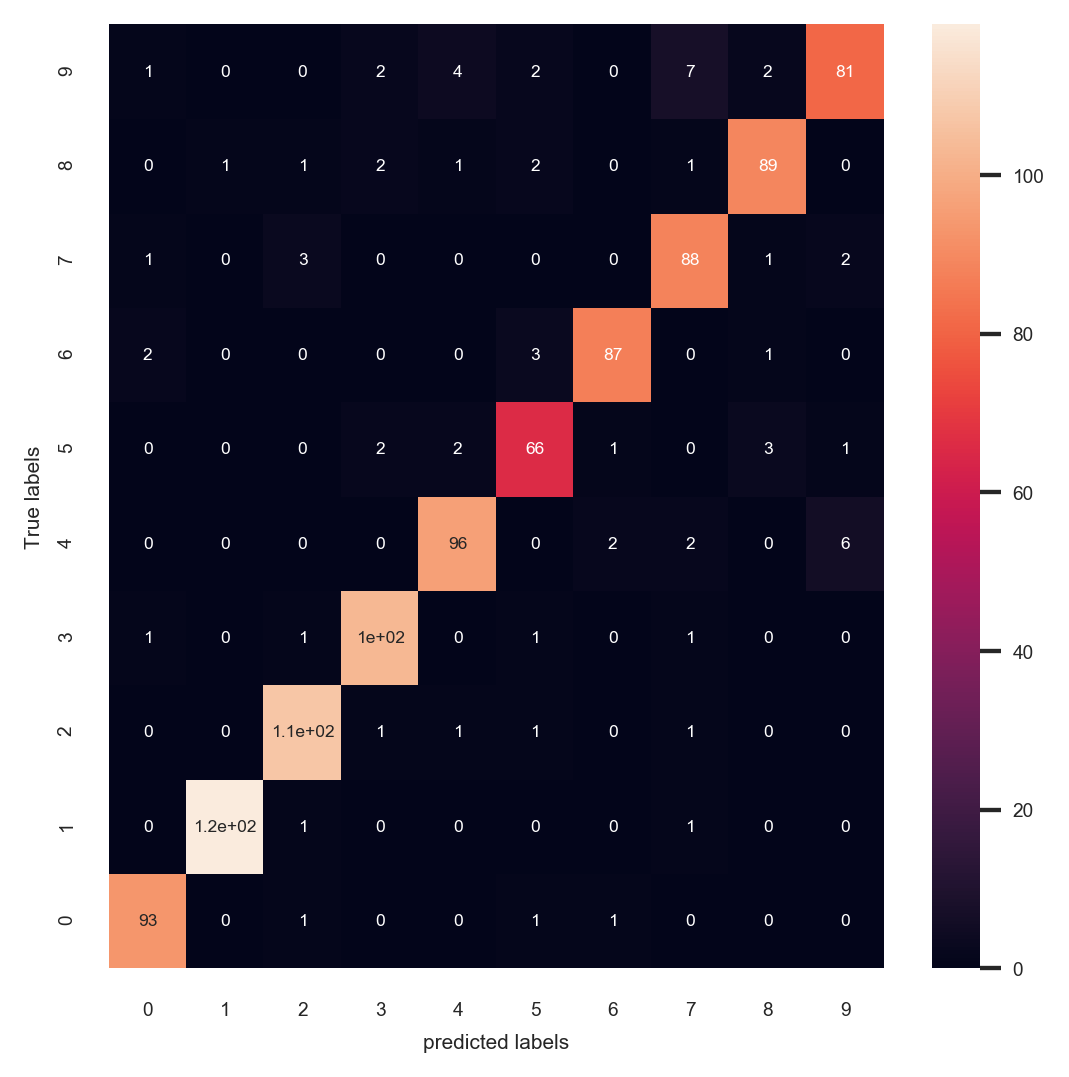

In [20]:
CM = confusion_matrix(label_test, test_label_predicted)

plt.figure(figsize = (5,5), dpi = 250)
sns.set(font_scale = 0.5)
sns.heatmap(CM, annot = True, annot_kws = {"size": 5})
plt.ylim([0, 10]);
plt.ylabel('True labels');
plt.xlabel('predicted labels');